# HOOLI - Мы сделаем!

<img src="include/unspecified.jpeg">

# Model M/M/1/N

<img src="include/jpTi8JZkULY.jpg">

$$\Omega = \big\{ \omega = \big\{ \omega_{1}, \omega_{2}, ... , \omega_{n}, ... \big\}: \omega_{i} \in \big\{0,1\big\} \big\}$$
$$\omega_{i} = \text{1 - at the time } t_{i} \text{ request arrives}$$
$$\omega_{i} = \text{0 - at the time } t_{i} \text{ request goes away}$$
$$F = 2^{ \Omega } $$
$$P \big( \big\{ \omega_{ i } = 1 \big\} \big) = \frac{ \lambda }{ \lambda + \mu } $$
$$P \big( \big\{ \omega_{ i } = 0 \big\} \big) = \frac{ \mu }{ \lambda + \mu }$$

$$X_i(\omega) = \max \{ \sum_{j=1}^{i}\omega_j - \sum_{j=1}^{1}(1-\omega_j), 0\} $$

$$P \big(X_{i+1} \big( \omega \big) = n + 1 / X_{i+1} \big( \omega \big) = n \big) = \frac{ \lambda }{ \lambda + \mu } $$

$$P \big(X_{i+1} \big( \omega \big) = n - 1 / X_{i+1} \big( \omega \big) = n \big) = \frac{ \mu }{ \lambda + \mu }$$

*Transition rate matrix:*

$$\mathbb{P} = \begin{bmatrix}\quad & \big(0\big) & \big(1\big) & \big(2\big) & \big(3\big) & ... & \big(N-1\big) & \big(N\big) \\ \big(0\big) & 0 & \frac{ \lambda }{ \lambda + \mu } & 0 & 0 & ... & 0 & 0 \\ \big(1\big) & \frac{ \mu }{ \lambda + \mu } & 0 & \frac{ \lambda }{ \lambda + \mu } & 0 & ... & 0 & 0 \\ \big(2\big) & 0 & \frac{ \mu }{ \lambda + \mu } & 0 & \frac{ \lambda }{ \lambda + \mu } & ... & 0 & 0 \\ \big(3\big) & 0 & 0 & \frac{ \mu }{ \lambda + \mu } & 0 & ... & 0 & 0 \\ ... & ... & ... & ... & ... & ... & ... & ... \\ \big(N-1\big) & 0 & 0 & 0 & 0 & ... & 0 & \frac{ \lambda }{ \mu + \lambda } \\ \big(N\big) & 0 & 0 & 0 & 0 & ... & \frac{ \mu }{ \lambda + \mu } & 0 \end{bmatrix}$$

*Get stationary distribution*

$$ \Pi_{i} = \Pi_{i - 1 } + \big( \frac{ \lambda }{ \mu } \big)^{i} \Pi_{0}$$
$$\Pi_{0} = \frac{1}{ \sum_{i = 0}^{n} \sum_{j = 0}^{i} \big( \frac{ \lambda }{ \mu } \big)^j }$$

In [21]:
def get_stationary_distribution(lmbda = 1/5, mu = 1/7, cap = 3):
    p = 0
    arr = []

    for i in range(cap):
        for j in range(i + 1):
            p += (lmbda / mu) ** j
    pi_0 = 1 / p

    p = 0
    for i in range(cap):
        p += (lmbda / mu) ** i
        arr.append(pi_0 * p)
    assert(sum(arr) == 1)
    return arr

get_stationary_distribution()

[0.12886597938144329, 0.30927835051546393, 0.5618556701030929]

# Model definition

In [22]:
import time
import numpy as np
import random
import matplotlib.pyplot as plt

In [23]:
def get_next_time(param):
    s = 0
    while s == 0:
        # Interval between arrivals averaging (1/param) seconds
        s = random.expovariate(param)
    return s


def MM1Ksimulation(capacity = 1, lmbd:float = 1, mu:float = 1, timeout = 1, test = False):
    assert capacity, "Max length of queue should be greater than 0"
    assert lmbd > 0 and mu > 0, "Your model parameters lambda and mu should be greater than 0"
    assert timeout, "Your experiment time should be greater than 0"

    queue, arrival_time, departure_time, num_in_q, waiting_time, wasted_time = [], [], [], [], [], []
    total_customers, lost_customers, total_served, waiting_customers = 0, 0, 0, 0

    # Compute time of next arrival.
    nextArrival = get_next_time(lmbd)
    
    # Compute time of next completed service.
    nextService = nextArrival + get_next_time(mu)
    empty_queue_counter = 0
    list_requirements_system = []
    time_to_serf = []
    waiting_time_q = []
    # Simulate the M/M/1 queue.
    timeout_start = time.time() 
    while time.time() < timeout_start + timeout:
        # Next event is an arrival.
        while nextArrival < nextService:
            # Simulate an arrival
            if len(queue) < capacity:
                queue.append(nextArrival)
                arrival_time.append(nextArrival)
                total_customers += 1
                #num_in_q.append(len(queue))
                if(len(queue)):
                    waiting_customers += 1      
            else:
                lost_customers  += 1
                total_customers += 1
            nextArrival += get_next_time(lmbd)

        # Next event is a service completion.
        arrival = queue.pop(0)
        total_served += 1
        list_requirements_system.append(len(queue))
        departure_time.append(nextService)
        waiting_time.append(nextService - arrival)
        num_in_q.append(len(queue))

        get_next_serv = get_next_time(mu)
        waiting_time_q.append(nextService - arrival - get_next_serv)

        # Update the queue.
        if not queue:
            empty_queue_counter += 1
            nextService = nextArrival + get_next_serv
        else:
            nextService = nextService + get_next_serv
        time_to_serf.append(get_next_serv)
    num_of_customers = len(arrival_time)
    arrival_time = arrival_time[:len(departure_time)]

    for i in range(1, len(departure_time)):
        if ((arrival_time[i]-departure_time[i-1])>0):
            wasted_time.append(arrival_time[i]-departure_time[i-1])
    if test: print(f"L = {np.mean(list_requirements_system)}, p_0 = {empty_queue_counter/len(departure_time)}")
    #print(f"Время в очереди = {np.mean(num_in_q) - np.mean(waiting_time_q)}")

    return      np.mean(waiting_time),              \
                lost_customers/total_customers,     \
                waiting_customers/num_of_customers, \
                np.mean(num_in_q),                  \
                sum(wasted_time)/departure_time[-1]

**Run algo**

In [24]:
avg_total_time,         \
lost_customers_prob,    \
waiting_customers_prob, \
avg_num_in_q,           \
wasted_time_prob        = MM1Ksimulation(capacity = 250, lmbd = 2, mu = 3, timeout = 10, test=True)
print(f"Среднее время пребывания в системе {avg_total_time:.2f}")
print(f"Вероятность ухода посетителя {lost_customers_prob:.2f}")
print(f"Вероятность ожидания {waiting_customers_prob:.2f}")
print(f"Среднее количество людей в очереди {avg_num_in_q:.2f}")
print(f"Вероятность простоя системы {wasted_time_prob:.2f}")

Среднее время пребывания в системе 1.00
Вероятность ухода посетителя 0.00
Вероятность ожидания 1.00
Среднее количество людей в очереди 2.00
Вероятность простоя системы 0.33


# Queuing system characteristics

$$\rho = \frac{ \lambda }{ \mu } $$
$$p_{0} = \frac{1 - \rho }{ 1 - \rho^{n+1} } $$
$$L = \frac{ \rho }{1 - \rho } - \frac{(n+1) \cdot \rho ^{n+1} } {1 - \rho ^{n+1} } $$
$$p_{n} = \frac{1 - \rho}{1 - \rho^{n+1} } $$
$$W = \frac{L}{ \lambda \cdot \big(1 - p_{n}\big) }$$

In [17]:
def print_some_metrics(_capacity, _lambda, _mu, _timeout):
    avg_total_time,         \
    lost_customers_prob,    \
    waiting_customers_prob, \
    avg_num_in_q,           \
    wasted_time_prob        = MM1Ksimulation(capacity = _capacity, lmbd = _lambda, mu = _mu, timeout = _timeout, test=True)
    print(f"Среднее время пребывания в системе {avg_total_time:.2f}")
    print(f"Вероятность ухода посетителя {lost_customers_prob:.2f}")
    print(f"Вероятность ожидания {waiting_customers_prob:.2f}")
    #print(f"Среднее количество людей в очереди {avg_num_in_q:.2f}")
    print(f"Вероятность простоя системы {wasted_time_prob:.2f}")

In [18]:
def expected(l, m, n):
    r = l/m
    p_0 = (1-r)/(1-r**(n+1))
    L = r/(1-r) - ((n+1)*r**(n+1))/(1-r**(n+1))
    p_n = (1-r)/(1-r**(n+1))*r**n
    W = L/(l*(1-p_n))
    if l < m: L_q = L + p_0 - 1
    else: L_q = L - p_0 + 1

    exp_avg_total_time = W
    exp_lost_customers_prob = p_n
    exp_waiting_customers_prob = min(l/l+m, 1)
    exp_avg_num_in_q = L_q
    exp_wasted_time_prob = (1-r)/(1-r**(n+2))

    print(f"L = {L}, p_0 = {p_0}")
    print(f"Среднее время пребывания в системе {exp_avg_total_time:.2f}")
    print(f"Вероятность ухода посетителя {exp_lost_customers_prob:.2f}")
    print(f"Вероятность ожидания {exp_waiting_customers_prob:.2f}")
    #print(f"Среднее количество людей в очереди {exp_avg_num_in_q:.2f}")
    print(f"Вероятность простоя системы {exp_wasted_time_prob:.2f}")

In [14]:
lambdas = np.arange(0.01, 2, 0.5)
mus = np.arange(0.01, 2, 0.5)
capacities = [x for x in range(50, 300, 50)]
timeouts = [x for x in range(1, 5, 3)]
#print(lambdas, mus, capacity, timeouts)
# for capacity in capacities:
#     for timeout in timeouts:
capacity = 50
timeout = 5
for lmbd in lambdas:
    for mu in mus:
        if mu == lmbd: continue
        print(f"Lambda = {lmbd}, Mu = {mu}, capacity = {capacity}, timeout = {timeout}\n")
        print("===========Practice============")
        print_some_metrics(capacity, lmbd, mu, timeout)
        print("===========Expected============")
        expected(lmbd, mu, capacity)
        print()


Lambda = 0.01, Mu = 0.51, capacity = 50, timeout = 5

===========Practice============
L = 0.020021447747535927, p_0 = 0.9803750652321198
Среднее время пребывания в системе 2.00
Вероятность ухода посетителя 0.00
Вероятность ожидания 1.00
Вероятность простоя системы 0.98
===========Expected============
L = 0.02, p_0 = 0.9803921568627451
Среднее время пребывания в системе 2.00
Вероятность ухода посетителя 0.00
Вероятность ожидания 1.00
Вероятность простоя системы 0.98

Lambda = 0.01, Mu = 1.01, capacity = 50, timeout = 5

===========Practice============
L = 0.00988704743534368, p_0 = 0.9902177652415806
Среднее время пребывания в системе 1.00
Вероятность ухода посетителя 0.00
Вероятность ожидания 1.00
Вероятность простоя системы 0.99
===========Expected============
L = 0.01, p_0 = 0.9900990099009901
Среднее время пребывания в системе 1.00
Вероятность ухода посетителя 0.00
Вероятность ожидания 1.00
Вероятность простоя системы 0.99

Lambda = 0.01, Mu = 1.51, capacity = 50, timeout = 5

=====

# Tests

In [25]:
def print_metrix(parameters, avg_t_t, lost_cust_p, waiting_cust_p, avg_len, wasted_t_p, param = "λ = None μ = None"):
    _, axs = plt.subplots(3, 2 ,figsize=(20,15))

    axs[0][0].plot(parameters, avg_t_t)
    axs[0][0].set_title('Среднее время нахождения в очереди')
    axs[0][0].set_xlabel(param)
    axs[0][0].set_ylabel('Time (s)')
    axs[0][0].grid(True)

    axs[0][1].plot(parameters, lost_cust_p)
    axs[0][1].set_title('Вероятность отказа')
    axs[0][1].set_xlabel(param)
    axs[0][1].set_ylabel('P')
    axs[0][1].grid(True)

    axs[1][0].plot(parameters, waiting_cust_p)
    axs[1][0].set_title('Вероятность ожидания')
    axs[1][0].set_xlabel(param)
    axs[1][0].set_ylabel('P')
    axs[1][0].grid(True)

    axs[1][1].plot(parameters, avg_len)
    axs[1][1].set_title('Средняя длина очереди')
    axs[1][1].set_xlabel(param)
    axs[1][1].set_ylabel('People (int)')
    axs[1][1].grid(True)

    axs[2][0].plot(parameters, wasted_t_p)
    axs[2][0].set_title('Вероятность простоя системы')
    axs[2][0].set_xlabel(param)
    axs[2][0].set_ylabel('P')
    axs[2][0].grid(True)

**lambda = mu**

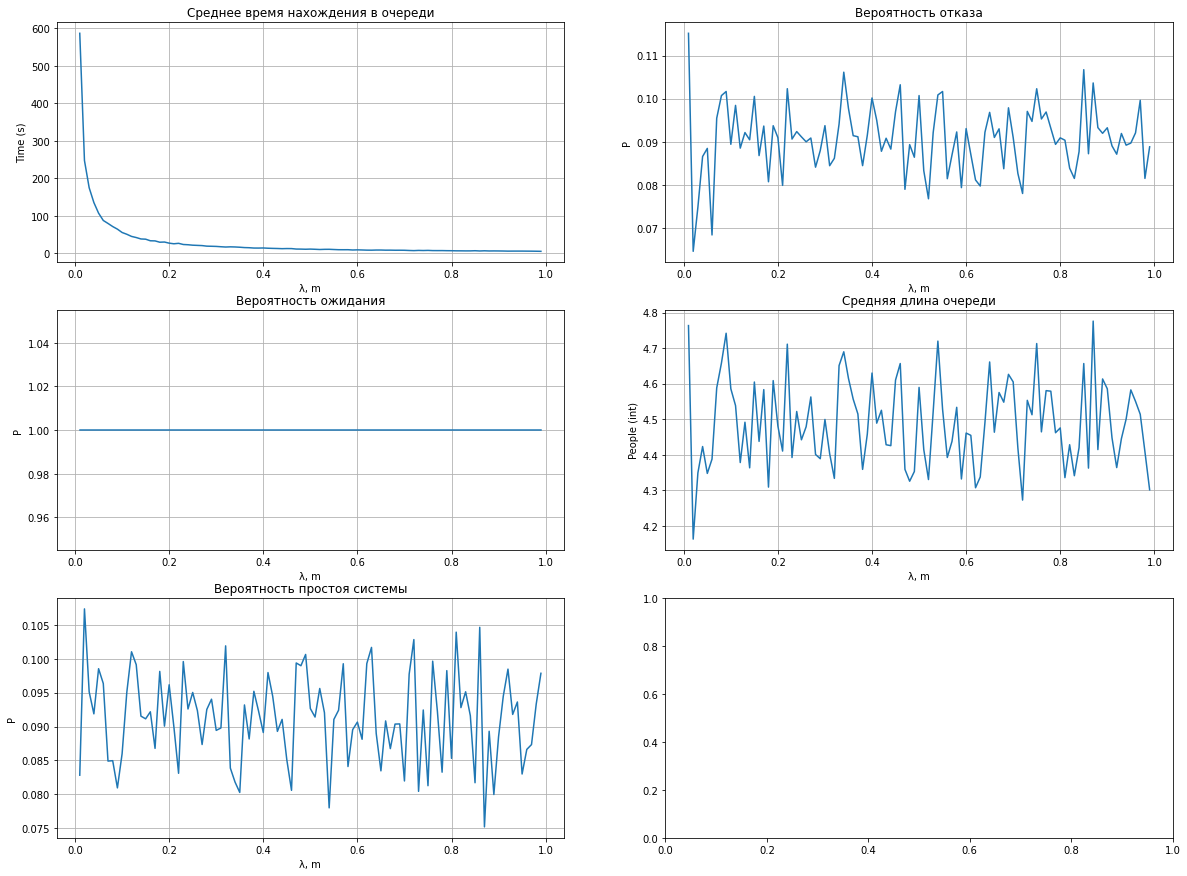

In [26]:
avg_t_t, lost_cust_p, waiting_cust_p, avg_len, wasted_t_p = [], [], [], [], []

parameters = np.arange(1/100, 1/1, 1/100)
for mu in parameters:
    lmbd = mu
    np.random.seed(int(lmbd*100))
    avg_total_time, lost_customers_prob, waiting_customers_prob, avg_num_in_q, wasted_time_prob = MM1Ksimulation(capacity = 10, lmbd = lmbd, mu = mu, timeout = 0.05)
    avg_t_t.append(avg_total_time)
    lost_cust_p.append(lost_customers_prob)
    waiting_cust_p.append(waiting_customers_prob)
    avg_len.append(avg_num_in_q)
    wasted_t_p.append(wasted_time_prob)

print_metrix(parameters, avg_t_t, lost_cust_p, waiting_cust_p, avg_len, wasted_t_p, "λ, m")

**lambda<mu**

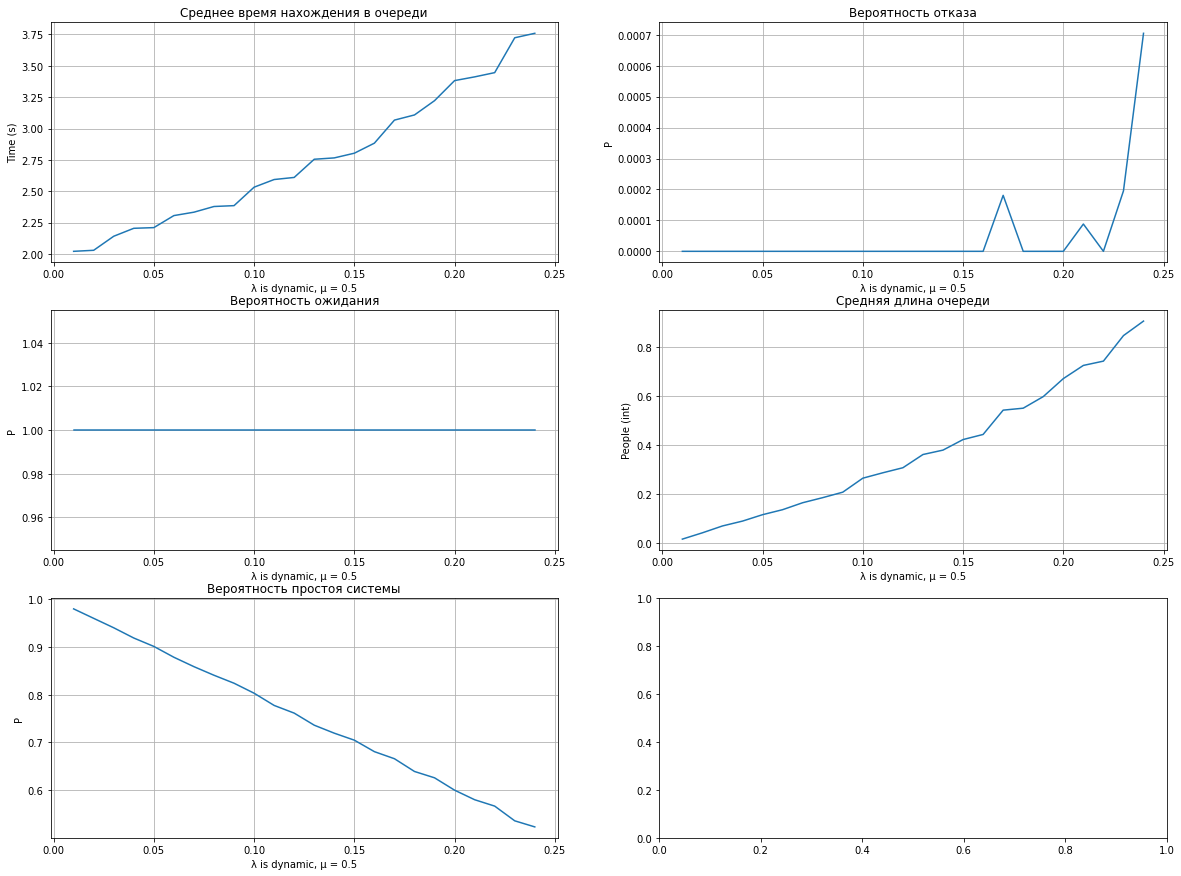

In [27]:
avg_t_t, lost_cust_p, waiting_cust_p, avg_len, wasted_t_p =[], [], [], [], []
mu = 1/2
parameters = np.arange(1/100, mu/2, 1/100)
#  УМЕНЬШЕНИЕ lambda все нормас
for lmbd in parameters:
    np.random.seed(int(lmbd*100))
    avg_total_time, lost_customers_prob, waiting_customers_prob, avg_num_in_q, wasted_time_prob = MM1Ksimulation(capacity = 10, lmbd = lmbd, mu = mu, timeout = 0.05)
    avg_t_t.append(avg_total_time)
    lost_cust_p.append(lost_customers_prob)
    waiting_cust_p.append(waiting_customers_prob)
    avg_len.append(avg_num_in_q)
    wasted_t_p.append(wasted_time_prob)

print_metrix(parameters, avg_t_t, lost_cust_p, waiting_cust_p, avg_len, wasted_t_p, f"λ is dynamic, μ = {mu}")

**lambda>mu**

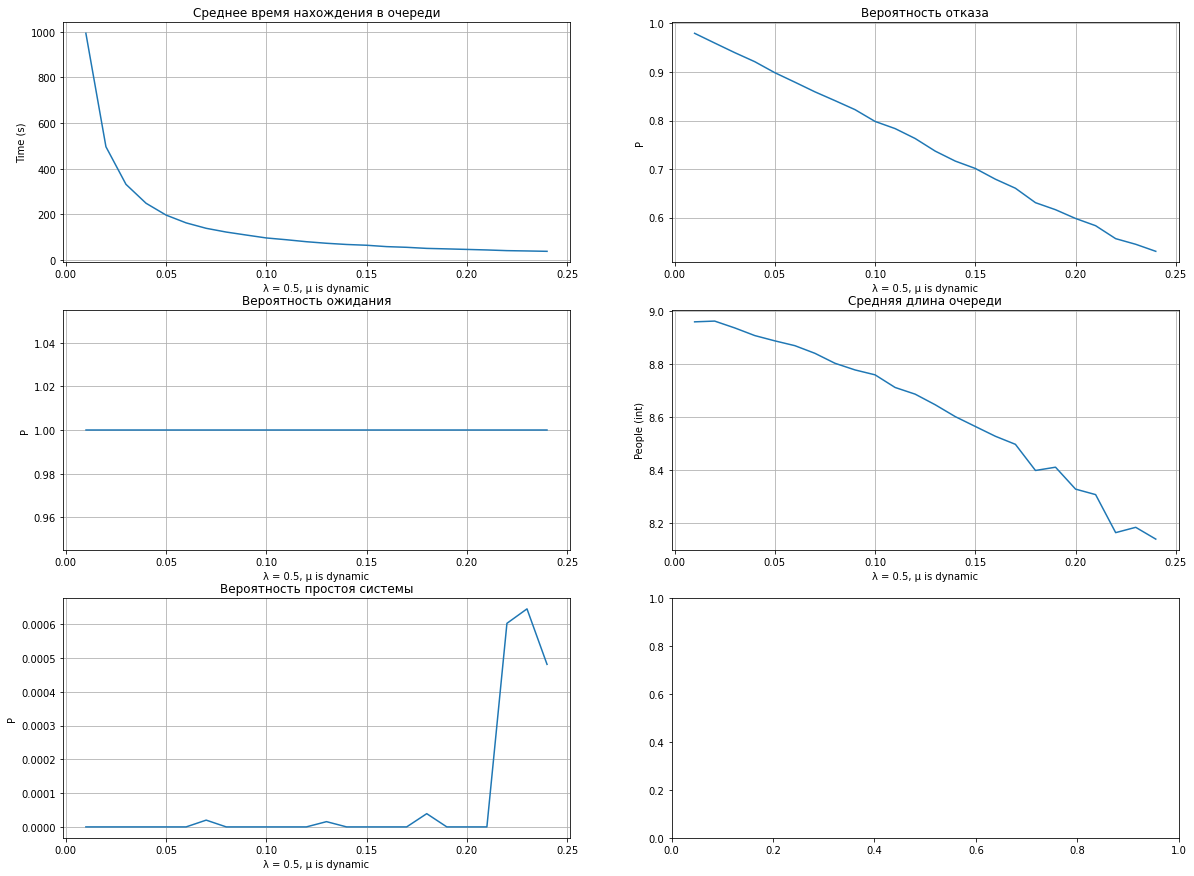

In [28]:
#metrics
avg_t_t,lost_cust_p,waiting_cust_p,avg_len,wasted_t_p = [],[],[],[],[]
lmbd = 1/2
parameters = np.arange(1/100, lmbd/2, 1/100)
#  УМЕНЬШЕНИЕ mu все нормас
for mu in parameters:
    np.random.seed(int(mu*100))
    avg_total_time, lost_customers_prob, waiting_customers_prob, avg_num_in_q, wasted_time_prob = MM1Ksimulation(10, lmbd, mu, 0.05)
    avg_t_t.append(avg_total_time)
    lost_cust_p.append(lost_customers_prob)
    waiting_cust_p.append(waiting_customers_prob)
    avg_len.append(avg_num_in_q)
    wasted_t_p.append(wasted_time_prob)

print_metrix(parameters, avg_t_t, lost_cust_p, waiting_cust_p, avg_len, wasted_t_p, f"λ = {lmbd}, μ is dynamic")

**Зафиксируем lambda и mu и проведем эксперименты с различными длинами очереди**

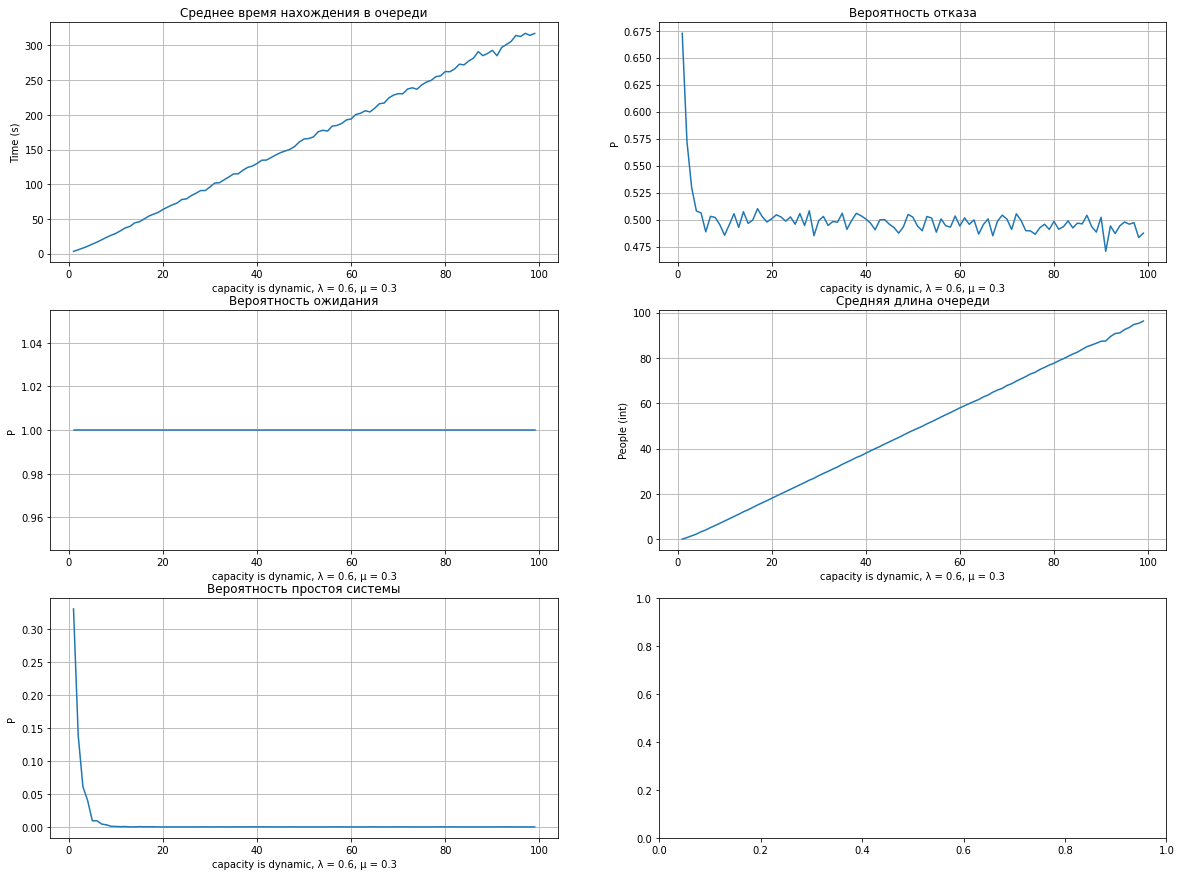

In [29]:
#metrics
avg_t_t,lost_cust_p,waiting_cust_p,avg_len,wasted_t_p = [],[],[],[],[]
lmbd = 0.6
mu = 0.3
capacity = 100
parameters = np.arange(1, capacity, 1)
for cap in parameters:
    np.random.seed(int(cap*100))
    avg_total_time, lost_customers_prob, waiting_customers_prob, avg_num_in_q, wasted_time_prob = MM1Ksimulation(cap, lmbd, mu, 0.05)
    avg_t_t.append(avg_total_time)
    lost_cust_p.append(lost_customers_prob)
    waiting_cust_p.append(waiting_customers_prob)
    avg_len.append(avg_num_in_q)
    wasted_t_p.append(wasted_time_prob)
    
print_metrix(parameters, avg_t_t, lost_cust_p, waiting_cust_p, avg_len, wasted_t_p, f"capacity is dynamic, λ = {lmbd}, μ = {mu}")

HOOLI - мы сделали